In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

In [64]:
# --- global variables --- #

hbar = 0.658 # eV fs
c = 299.792 # nm fs{-1}

m0 = 0.510 * 10e6 # eV
mu = 0.108 * m0 # eV

veps0 = 55.26 # e{2} eV{-1} nm{-1}
vepsS = 3.32
vepsW = 6.10

Lwell = 0.636 # nm
r0 = Lwell * (vepsW/(2*vepsS)) # nm

A = (8*(np.pi**2)*veps0*vepsS) # eV nm


In [121]:
# --- simulation parameters --- #

k_max = 0.75
N = 500
dk = k_max/N

k_vals = np.linspace(dk, k_max, N)

t_max = 2*np.pi
T = 250
dt = t_max/T

cos_vals = np.cos(np.linspace(0, 2*np.pi, T))

In [105]:
def RytovaKeldysh(ki, kj):

    q = np.sqrt(ki**2 + kj**2 - 2*ki*kj*cos_vals)
    V = np.sum(q)

    return A * V

In [21]:
def Coulomb(): # Riemann sum of the kj components

    V = np.zeros((N, N))

    for i in range(N):
        for j in range(N):

            V[i][j] = dk * k_vals[j] * RytovaKeldysh(k_vals[i], k_vals[j])

    return V

In [47]:
def WannierMatrix(): # construction of the Wannier matrix

    H = np.zeros((N, N))
    K = np.diag( (c**2 * hbar**2 * k_vals**2)/(2 * mu) ) # eV

    H = K - Coulomb()

    return H

In [123]:
eigenvalues, eigenvectors = np.linalg.eig(WannierMatrix())

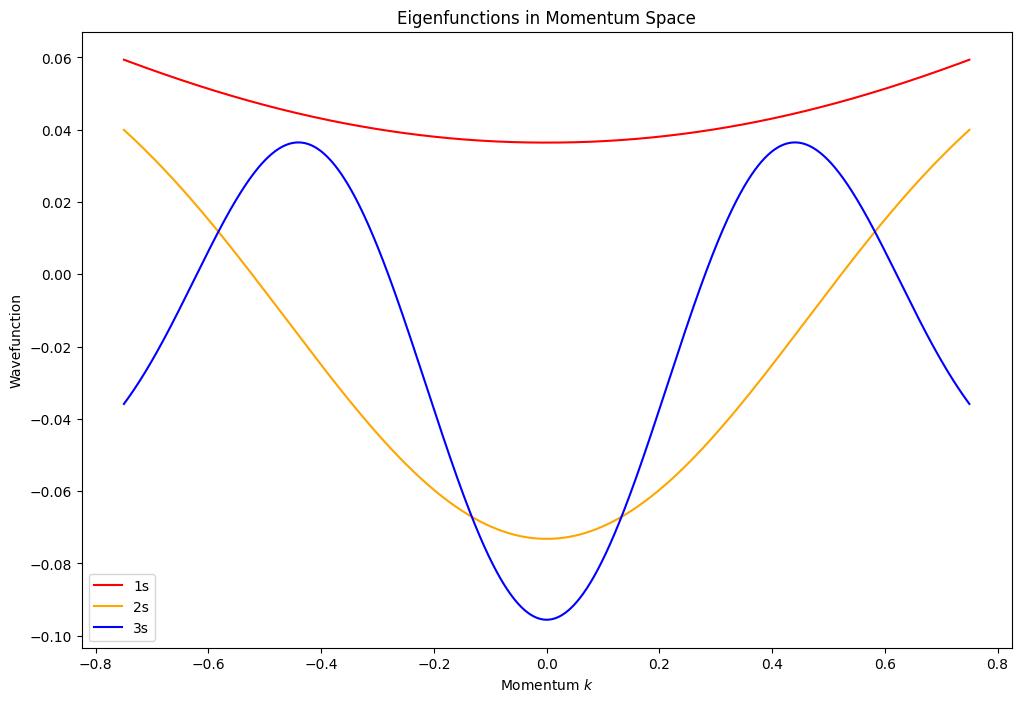

In [124]:
plot_x = np.concatenate((np.flip((-1)*k_vals), k_vals))

plt.figure(figsize=(12,8))
#for i in range(3):  # First 3 eigenfunctions
    #plt.plot(plot_x, np.concatenate((np.flip(eigenvectors[:,i]),eigenvectors[:,i])), label=f'{i+1}s')

plt.plot(plot_x, np.concatenate((np.flip(eigenvectors[:,0]),eigenvectors[:,0])), label=f'1s', c='red')
plt.plot(plot_x, np.concatenate((np.flip(eigenvectors[:,1]),eigenvectors[:,1])), label=f'2s', c='orange')
plt.plot(plot_x, np.concatenate((np.flip(eigenvectors[:,2]),eigenvectors[:,2])), label=f'3s', c='blue')

plt.xlabel('Momentum $k$')
#plt.xlim(-0.025, 0.025)
plt.ylabel('Wavefunction')
plt.title('Eigenfunctions in Momentum Space')
plt.legend()
plt.show()

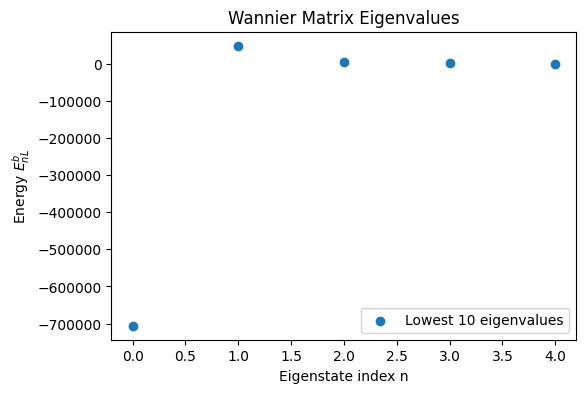

In [125]:
plt.figure(figsize=(6,4))
plt.scatter(range(5), eigenvalues[:5], label='Lowest 10 eigenvalues')
plt.xlabel('Eigenstate index n')
plt.ylabel('Energy $E_{nL}^b$')
plt.title('Wannier Matrix Eigenvalues')
plt.legend()
plt.show()